In [1]:
from scipy.stats import gaussian_kde
from tqdm import tqdm
import pytest
import os
from torchvision import transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import umap
import umap.plot
from sklearn.decomposition import PCA


/home/ctr26/gdrive/+projects/2021_mask_generator/mask_vae/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from ast import excepthandler
import sys
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import pyro
import pytorch_lightning as pl
from torch.utils.data import random_split, DataLoader
import glob

# Note - you must have torchvision installed for this example
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from skimage.measure import regionprops
from torchvision.transforms.functional import crop
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from pytorch_lightning import loggers as pl_loggers
import torchvision
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
from scipy.ndimage import convolve, sobel
from skimage.measure import find_contours
from scipy.interpolate import interp1d
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from mask_vae.datasets import DatasetGlob
from mask_vae.transforms import (
    ImagetoDistogram,
    cropCentroid,
    DistogramToCoords,
    CropCentroidPipeline,
)
from mask_vae.transforms import (
    DistogramToCoords,
    MaskToDistogramPipeline,
    AsymmetricDistogramToMaskPipeline,
)
from mask_vae.transforms import (
    DistogramToMaskPipeline,
    AsymmetricDistogramToSymmetricDistogram,
    AsymmetricDistogramToCoordsPipeline,
)

from mask_vae.models import AutoEncoder, VAE, VQ_VAE, Mask_VAE
from mask_vae.lightning import LitAutoEncoderTorch, LitAutoEncoderPyro

interp_size = 128 * 4

window_size = 128 * 4
batch_size = 32
num_training_updates = 15000

num_hiddens = 64
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

train_dataset_glob = "data/stage1_train/*/masks/*.png"
train_dataset_glob = "data/BBBC010_v1_foreground_eachworm/*.png"


In [3]:
# def my_collate(batch):
#     batch = list(filter(lambda x: x is not None, batch))
#     return torch.utils.data.dataloader.default_collate(batch)

# test_dataloader_glob=os.path.join(os.path.expanduser("~"),
# "data-science-bowl-2018/stage1_test/*/masks/*.png")


transformer_crop = CropCentroidPipeline(window_size)
transformer_dist = MaskToDistogramPipeline(window_size, interp_size)
transformer_coords = DistogramToCoords(window_size)


transform = transforms.Compose(
    [
        transformer_crop,
        transformer_dist,
    ]
)


# train_dataset_raw = DatasetGlob(train_dataset_glob)
# train_dataset_crop = DatasetGlob(
#     train_dataset_glob, transform=CropCentroidPipeline(window_size))
train_dataset = DatasetGlob(train_dataset_glob, transform=transformer_dist)
train_dataset_crop = DatasetGlob(train_dataset_glob, transform=transformer_crop)
train_dataset_dist = DatasetGlob(train_dataset_glob, transform=transform)

train_dataset[0]
train_dataset[0:2]

[tensor([[[0.0000, 0.0011, 0.0017,  ..., 0.0014, 0.0007, 0.0000],
          [0.0011, 0.0000, 0.0007,  ..., 0.0023, 0.0017, 0.0011],
          [0.0017, 0.0007, 0.0000,  ..., 0.0028, 0.0022, 0.0017],
          ...,
          [0.0014, 0.0023, 0.0028,  ..., 0.0000, 0.0007, 0.0014],
          [0.0007, 0.0017, 0.0022,  ..., 0.0007, 0.0000, 0.0007],
          [0.0000, 0.0011, 0.0017,  ..., 0.0014, 0.0007, 0.0000]]]),
 tensor([[[0.0000, 0.0008, 0.0015,  ..., 0.0010, 0.0006, 0.0000],
          [0.0008, 0.0000, 0.0006,  ..., 0.0017, 0.0014, 0.0008],
          [0.0015, 0.0006, 0.0000,  ..., 0.0023, 0.0020, 0.0015],
          ...,
          [0.0010, 0.0017, 0.0023,  ..., 0.0000, 0.0006, 0.0010],
          [0.0006, 0.0014, 0.0020,  ..., 0.0006, 0.0000, 0.0006],
          [0.0000, 0.0008, 0.0015,  ..., 0.0010, 0.0006, 0.0000]]])]

In [4]:

# train_dataset_crop_filtered = [x for x in train_dataset_crop if x is not None]
# img_squeeze = train_dataset_crop[0].unsqueeze(0)
# img_crop = train_dataset_crop[0]

In [5]:
# dataloader = DataLoader(train_dataset, batch_size=batch_size,
#                         shuffle=True, num_workers=8, pin_memory=True,collate_fn=my_collate)

ckpt_file = "checkpoints/last.ckpt"
# ckpt_file = "BBBC010_v1_foreground_eachworm/last.ckpt"


model = Mask_VAE(VQ_VAE(channels=1))
# model = Mask_VAE(VAE(1, 64, image_dims=(interp_size, interp_size)))

lit_model = LitAutoEncoderTorch(model)
model = LitAutoEncoderTorch(model).load_from_checkpoint(ckpt_file, model=model)


# model = LitAutoEncoder.load_from_checkpoint(
#     ckpt_file, model=Mask_VAE(VQ_VAE(channels=1)))
# transformer_dist = MaskToDistogramPipeline(window_size, interp_size)

# print(model)
# trainer.fit(model,
#             ckpt_path="checkpoints/last.ckpt")
# model = lit_model.load_from_checkpoint(checkpoint_path="checkpoints/last.ckpt")
# test_img = torch.tensor(np.zeros((1, 96, 96)), dtype=torch.float32)
# train_dataset = DatasetGlob(train_dataset_glob, transform=transformer_dist)

0


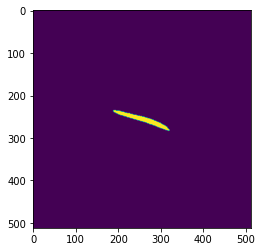

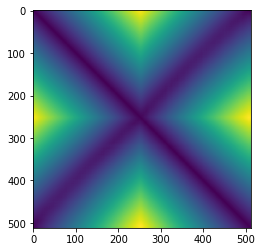

1


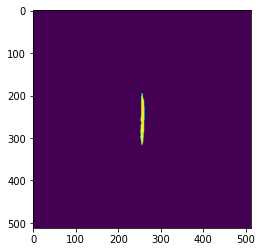

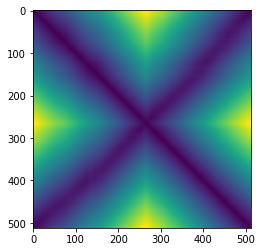

2


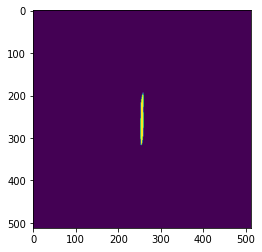

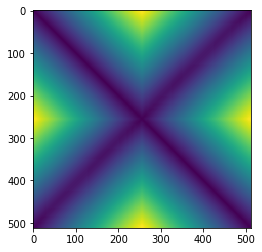

3


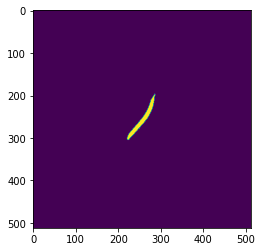

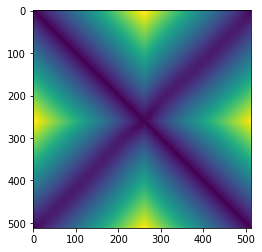

4


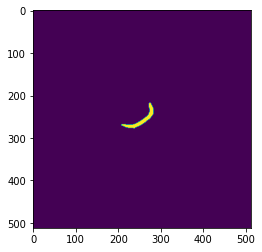

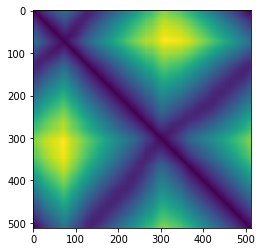

5


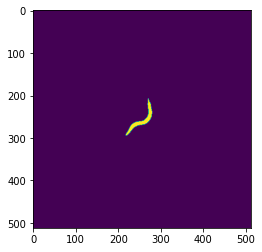

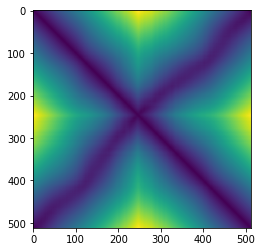

6


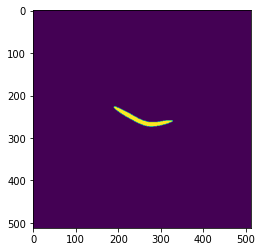

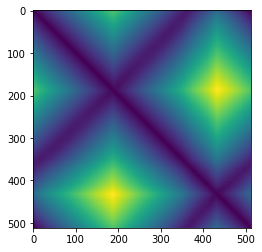

7


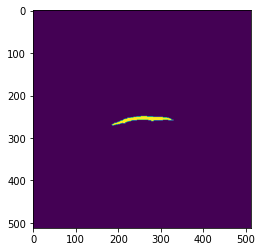

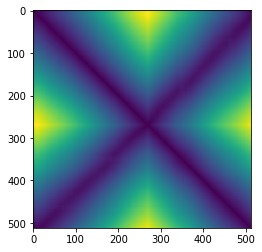

8


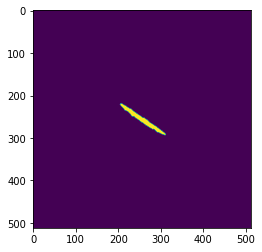

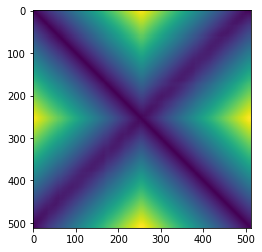

9


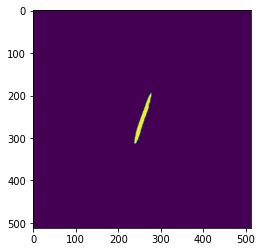

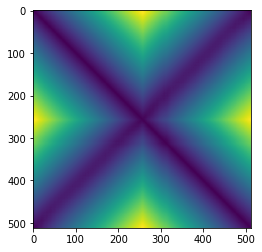

In [6]:
for worm_id in range(0, 10):
    print(worm_id)
    test_mask = train_dataset_crop[worm_id].unsqueeze(0)
    test_img = train_dataset[worm_id].unsqueeze(0)
    # test_dist= train_dataset[worm_id].unsqueeze(0)

    plt.imshow(test_mask[0][0])
    plt.show()

    plt.imshow(test_img[0][0])
    plt.show()

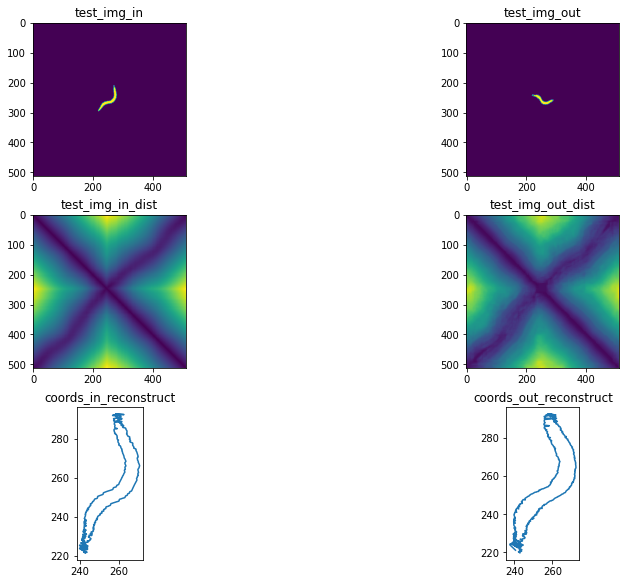

In [7]:

# loss, y_prime, _, = model.forward(test_img)
# y_prime = y_prime.detach().numpy()
# plt.imshow(y_prime[0][0])
# plt.show()


worm_id = 5
test_img_in = train_dataset_crop[worm_id].unsqueeze(0)
test_img_in_dist = train_dataset[worm_id].unsqueeze(0)

z, log_var = model.encode(test_img_in_dist)
z_np = z.detach().numpy()

z_np.flatten()
width_z = np.floor(np.sqrt(len(z_np.flatten()))).astype(int)
height_z = (len(z_np.flatten()) / width_z).astype(int)


# z_gen = z

test_img_out_dist = model.decode(z).detach().numpy()
# plt.imshow(y_prime[0][0])
# plt.show()


# y_gen = model.decode(z).detach().numpy()
# plt.imshow(y_gen[0][0])
# plt.show()


coords_out_reconstruct = AsymmetricDistogramToCoordsPipeline(window_size)(
    test_img_out_dist
)

# coords_in_reconstruct = DistogramToCoords(window_size)(test_img_in_dist)
coords_in_reconstruct = DistogramToCoords(window_size)(
    test_img_in_dist.detach().numpy()
)


test_img_out = AsymmetricDistogramToMaskPipeline(window_size)(test_img_out_dist)
# test_img_in = AsymmetricDistogramToMaskPipeline(window_size)(test_img_in_dist)

# plt.imshow(mask_reconstruct[0][0])
# plt.show()


axd = plt.figure(constrained_layout=True, figsize=(12, 8)).subplot_mosaic(
    """
    Aa
    Bb
    Cc
    """,
)

axd["A"].imshow(test_img_in[0][0])
axd["A"].set_title("test_img_in")

axd["a"].imshow(test_img_out[0][0])
axd["a"].set_title("test_img_out")

axd["B"].imshow(test_img_in_dist[0][0])
axd["B"].set_title("test_img_in_dist")

axd["b"].imshow(test_img_out_dist[0][0])
axd["b"].set_title("test_img_out_dist")

axd["c"].plot(coords_out_reconstruct[0, 0, :, 0], coords_out_reconstruct[0, 0, :, 1])
axd["c"].set_aspect("equal")
axd["c"].set_title("coords_out_reconstruct")
axd["C"].plot(coords_in_reconstruct[0, 0, :, 0], coords_in_reconstruct[0, 0, :, 1])
axd["C"].set_aspect("equal")
axd["C"].set_title("coords_in_reconstruct")

# axd["Z"].imshow(z_np.reshape((width_z,height_z)))
# axd["Z"].set_title("z_np")

# axd["M"].text(0.5,0.5,"Model")
# axd["n"].arrow(0, 0, 0, 40)
# axd["m"].arrow(0, 0, 40, 20)
# axd["p"].arrow(0, 0, 40, 20)
# axd["o"].arrow(0, 0, 40, 20)


# axd["F"].imshow(mask_reconstruct[0][0])

plt.show()

# z = model.model.model._encoder(test_img)
# z = model.model.model._pre_vq_conv(z)

In [8]:

# gen = model.sample(1).detach().numpy()

# mask_gen = AsymmetricDistogramToMaskPipeline(window_size)(gen)

# plt.title("gen_1")
# plt.imshow(mask_gen[0][0])
# plt.show()

In [9]:
z_list = []
for data in tqdm(train_dataset):
    if data is not None:
        z, mu = model.encode(data.unsqueeze(0))
        z_list.append(z)
    if len(z_list) >= 1000:
        break
latent = torch.stack(z_list).detach().numpy()

 71%|███████   | 999/1407 [03:36<01:28,  4.61it/s]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


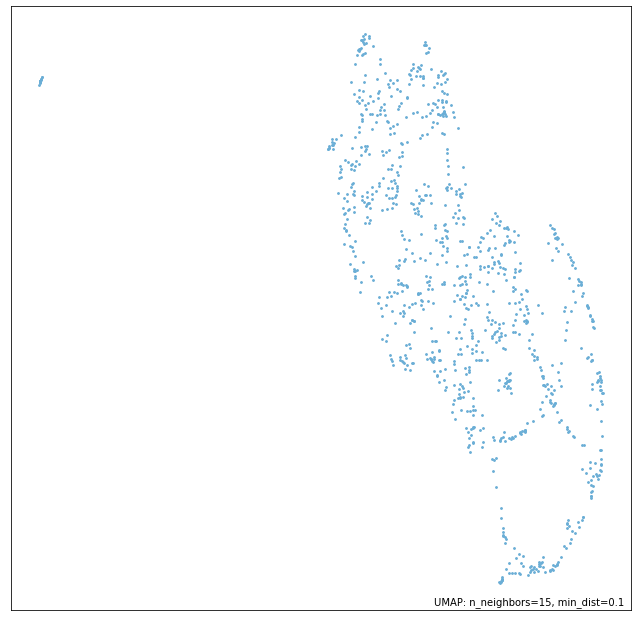

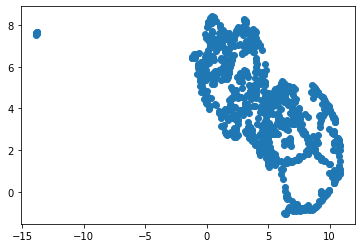

In [10]:
latent_umap = latent.reshape(latent.shape[0], -1)
unfit_umap = umap.UMAP(n_neighbors=3, min_dist=0.1, metric="cosine", random_state=42)
unfit_umap = umap.UMAP(random_state=42)

fit_umap = unfit_umap.fit(latent_umap)
proj = fit_umap.transform(latent_umap)

worm_z = fit_umap.transform(z.detach().numpy().reshape((1, latent_umap[0].shape[0])))

umap.plot.points(fit_umap)
plt.show()
plt.scatter(proj[:, 0], proj[:, 1])
plt.show()

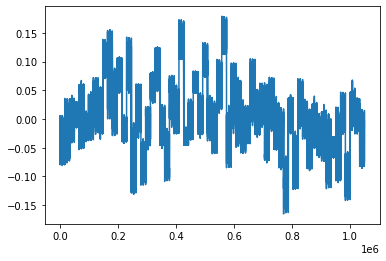

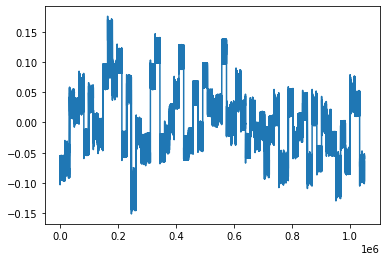

In [11]:

pc_1 = fit_umap.inverse_transform(np.array([[1, 0]]))
pc_2 = fit_umap.inverse_transform(np.array([[0, 1]]))

plt.plot(pc_1.T)
plt.show()
plt.plot(pc_2.T)
plt.show()

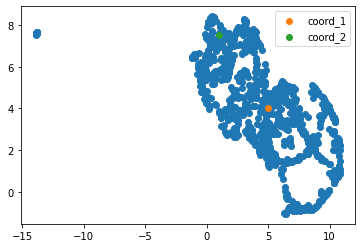

In [12]:
coord_1 = np.array([[0, -1]])
coord_2 = np.array([[-1, 10]])

coord_1 = np.array([[5, 4]])
coord_2 = np.array([[-13.8, 7.5]])
coord_2 = np.array([[1, 7.5]])


plt.scatter(proj[:, 0], proj[:, 1])
plt.scatter(coord_1[:, 0], coord_1[:, 1], label="coord_1")
plt.scatter(coord_2[:, 0], coord_2[:, 1], label="coord_2")
plt.legend()
plt.show()


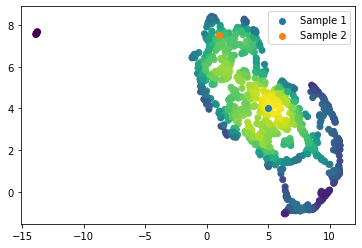

In [13]:
from scipy.stats import gaussian_kde

z = gaussian_kde(proj.T)(proj.T)

plt.scatter(proj[:, 0], proj[:, 1], c=gaussian_kde(proj.T)(proj.T))
plt.scatter(coord_1[:, 0], coord_1[:, 1], label="Sample 1")
plt.scatter(coord_2[:, 0], coord_2[:, 1], label="Sample 2")
plt.legend()
plt.show()



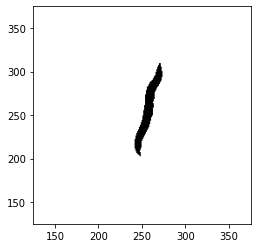

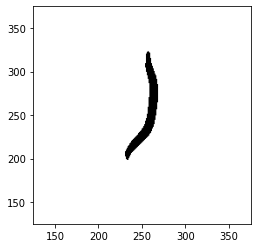

In [14]:

from scipy.spatial import distance


def closest_node(node, nodes):
    closest_index = distance.cdist([node], nodes).argmin()
    return nodes[closest_index], closest_index


real_worm_near_1_coord, real_worm_near_1_index = closest_node(coord_1[0], proj)
real_worm_near_2_coord, real_worm_near_2_index = closest_node(coord_2[0], proj)


real_worm_1 = train_dataset_crop[real_worm_near_1_index].unsqueeze(0)
plt.imshow(real_worm_1[0][0], cmap="binary")
plt.xlim(0.25 * 500, 0.75 * 500)
plt.ylim(0.25 * 500, 0.75 * 500)
plt.show()

real_worm_2 = train_dataset_crop[real_worm_near_2_index].unsqueeze(0)
plt.imshow(real_worm_2[0][0], cmap="binary")
plt.xlim(0.25 * 500, 0.75 * 500)
plt.ylim(0.25 * 500, 0.75 * 500)
plt.show()


In [15]:

cluster_1 = fit_umap.inverse_transform(coord_1)
cluster_2 = fit_umap.inverse_transform(coord_2)

cluster_1_z = cluster_1.reshape((z.shape))
cluster_2_z = cluster_2.reshape((z.shape))

z_cluster_1 = model.decode(torch.tensor(cluster_1_z)).detach().numpy()
z_cluster_2 = model.decode(torch.tensor(cluster_2_z)).detach().numpy()

mask_1 = AsymmetricDistogramToMaskPipeline(window_size)(z_cluster_1)
mask_2 = AsymmetricDistogramToMaskPipeline(window_size)(z_cluster_2)

contour_1 = AsymmetricDistogramToCoordsPipeline(window_size)(z_cluster_1)
contour_2 = AsymmetricDistogramToCoordsPipeline(window_size)(z_cluster_2)


# plt.title("contour_")
# plt.scatter(contour_1[0][0][:, 0],contour_1[0][0][:, 1])
# plt.show()

# plt.title("contour_2")
# plt.scatter(contour_2[0][0][:, 0],contour_2[0][0][:, 1])
# plt.show()

plt.title("Sample 1")
plt.imshow(mask_1[0][0], cmap="binary")
plt.xlim(0.25 * 500, 0.75 * 500)
plt.ylim(0.25 * 500, 0.75 * 500)
plt.show()
plt.title("Sample 2")
plt.imshow(mask_2[0][0], cmap="binary")
plt.xlim(0.25 * 500, 0.75 * 500)
plt.ylim(0.25 * 500, 0.75 * 500)
plt.show()



ValueError: cannot reshape array of size 1048576 into shape (1000,)

In [ ]:
import matplotlib

axd = plt.figure(constrained_layout=True, figsize=(13, 7), dpi=600).subplot_mosaic(
    """
    AAABC
    AAADE
    """
)

axd["A"].set_title("Latent space")
axd["A"].scatter(proj[:, 0], proj[:, 1], c=gaussian_kde(proj.T)(proj.T))
axd["A"].scatter(coord_1[:, 0], coord_1[:, 1], label="Sample A")
axd["A"].scatter(coord_2[:, 0], coord_2[:, 1], label="Sample B")
axd["A"].legend(loc="upper left")
axd["B"].imshow(real_worm_1[0][0], cmap="binary")
axd["B"].set_title(f"A: Real data at {np.around(real_worm_near_1_coord,3)}")
axd["C"].imshow(real_worm_2[0][0], cmap="binary")
axd["C"].set_title(f"B: Real data at {np.around(real_worm_near_2_coord,3)}")
axd["D"].imshow(
    mask_1[0][0], cmap=matplotlib.colors.ListedColormap(["white", "tab:blue"])
)
axd["D"].set_title(f"A: Generated data at {np.around(coord_1[0],3)}")
axd["E"].imshow(
    mask_2[0][0], cmap=matplotlib.colors.ListedColormap(["white", "tab:orange"])
)
axd["E"].set_title(f"B: Generated data at {np.around(coord_2[0],3)}")

# plt.tight_layout()
plt.savefig("latentspace.pdf")
plt.show()

# #  %%

# from scipy.spatial import ConvexHull, convex_hull_plot_2d

# hull = ConvexHull(proj)
# plt.plot(proj[hull.vertices,0], proj[hull.vertices,1], 'r--', lw=2)

: 

: 

: 

In [ ]:
embed = model.get_embedding()

proj = PCA().fit_transform(embed)
# proj = umap.UMAP(n_neighbors=3,
#                  min_dist=0.1,
#                  metric='cosine').fit_transform(embed)
fit_umap = umap.UMAP(n_neighbors=3, min_dist=0.1, metric="cosine").fit(embed)
proj = fit_umap.transform(embed)

pc_1 = fit_umap.inverse_transform(np.array([[0, 10]]))
pc_2 = fit_umap.inverse_transform(np.array([[0, 1]]))

plt.scatter(proj[:, 0], proj[:, 1])
plt.show()

: 

In [ ]:
# fig = plt.figure())
# grid = ImageGrid(fig, 111,  # similar to subplot(111)
#                  nrows_ncols=(10,2),  # creates 2x2 grid of axes
#                  axes_pad=0.1,  # pad between axes in inch.
#                  )
fig, ax = plt.subplots(10, 2, figsize=(4, 20))

for i in range(10):
    z_random = torch.normal(torch.zeros_like(z), torch.ones_like(z))
    # z_random = torch.ones_like(z)
    z_random = z + torch.normal(torch.zeros_like(z), torch.ones_like(z)) / 2
    generated_image_dist = model.decode(z_random).detach().numpy()
    # dist_stack = np.stack(
    #     [generated_image_dist[0], np.transpose(generated_image_dist[0],)], axis=0)
    dist_stack = np.stack(
        [generated_image_dist, generated_image_dist.transpose(0, 1, 3, 2)], axis=0
    )

    symmetric_generated_image_dist = np.max(dist_stack, axis=0)
    # print(symmetric_generated_image_dist.shape)
    # plt.imshow(symmetric_generated_image_dist[0][0])
    # plt.savefig("test_dist.png")
    # plt.show()

    # plt.imshow(symmetric_generated_image_dist[0][0])
    # plt.savefig("test_dist.png")
    # plt.show()

    coords = DistogramToCoords(window_size)(symmetric_generated_image_dist)
    # plt.scatter(coords[0, :, 0], coords[0, :, 1])
    # plt.show()
    # mask = DistogramToMaskPipeline(window_size)(
    #     symmetric_generated_image_dist[0])
    mask = AsymmetricDistogramToMaskPipeline(window_size)(generated_image_dist)
    # generated_image = model.model.mask_from_latent(z_random,window_size)
    # plt.imshow((mask[0]))
    # plt.savefig("test_dist_mask.png")
    # plt.show()

    # plt.imshow(train_dataset_crop[0][0])
    # plt.show()

    ax[i][0].imshow(test_mask[0][0])
    ax[i][1].imshow(mask[0][0])
plt.show()



: 

: 